#### This notebook presents the comparison between networks trained with classical stochastic gradient descent (SGD) and containing dropout units, versus networks trained with Delay compensation asynchronous stochastic gradient descent (DC-ASGD).


In [1]:
# !pip install requests jupyter
!pip install mxnet-cu110
import os
import mxnet as mx
from mxnet import gluon
from mxnet.gluon.data.vision import transforms
from mxnet import gluon, optimizer
from mxnet.gluon.model_zoo import vision
import math
import numpy as np

# Uncomment the following line if matplotlib is not installed.
# !pip install matplotlib

from mxnet import nd, gluon, init, autograd,gpu, metric

from mxnet.gluon import nn
from mxnet.gluon.data.vision import datasets, transforms
from IPython import display
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from matplotlib import pyplot as plt
from mxnet import image
from mxnet.gluon import data as gdata, utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 327.3 MB 6.2 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
def gpu_device(gpu_number=0):
    try:
        _ = mx.nd.array([1, 2, 3], ctx=mx.gpu(gpu_number))
    except mx.MXNetError:
        return None
    return mx.gpu(gpu_number)
print(gpu_device(0))

gpu(0)


##NETWORK DEFINITIONS :

In [29]:
# This simple network allows us to test our hypotheses on classical datasets (MNIST and FashionMNIST)
net = nn.Sequential()
net.add(nn.Conv2D(channels=32, kernel_size=6, activation='relu'),
        nn.BatchNorm(),
        nn.Activation('relu'),
        nn.Conv2D(channels=32, kernel_size=6, activation='relu'),
        nn.BatchNorm(),
        nn.Activation('relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(128),
        nn.BatchNorm(),
        nn.Activation('relu'),
        nn.Dense(10),
        nn.BatchNorm(),
        nn.Activation('softrelu')
)

In [30]:
# This network is the same as the one above, only we added dropout units after each activation.
net_dropout = nn.Sequential()
net_dropout.add(nn.Conv2D(channels=32, kernel_size=6, activation='relu'),
                nn.BatchNorm(),
                nn.Activation('relu'),
                nn.Dropout(0.5),
                nn.Conv2D(channels=32, kernel_size=6, activation='relu'),
                nn.BatchNorm(),
                nn.Activation('relu'),
                nn.Dropout(0.5),
                nn.MaxPool2D(pool_size=2, strides=2),
                nn.Flatten(),
                nn.Dense(128),
                nn.BatchNorm(),
                nn.Activation('relu'),
                nn.Dropout(0.5),
                nn.Dense(10),
                nn.BatchNorm(),
                nn.Activation('softrelu')
)

In [7]:
# Definition of the cross-entropy loss
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [8]:
def acc(output, label):
    # output: (batch, num_output) float32 ndarray
    # label: (batch, ) int32 ndarray
    return (output.argmax(axis=1) ==
            label.astype('float32')).mean().asscalar()

## Training function :

In [9]:
# This function trains the model using the parameters passed as arguments, on the datasets passed as arguments.
def train_model(network, optimizer_, train_data, valid_data, batch_size, epochs):
"""network : which network to train
  optimizer_ : which optimizer to use
  train_data : what dataset to train on
  valid_data : what dataset to validate on
  batch_size : what batch_size to use
  epochs : number of epochs to train the network on """

  trainer = gluon.Trainer(network.collect_params(), optimizer=optimizer_)
  test_acc = []
  train_loss_ = []
  train_acc_ = []
  time_per_epochs = []
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc, valid_acc = 0., 0., 0.
      tic = time.time()
      
      #for data, label in tqdm(train_data):
      for data, label in train_data:
          data = data.as_in_context(mx.gpu(0))
          label = label.as_in_context(mx.gpu(0))

          # forward + backward
          with autograd.record():
              loss = softmax_cross_entropy(network(data), label)
          
          loss.backward()
          # update parameters
          
          trainer.step(batch_size)
          # calculate training metrics
          train_loss += loss.mean().asscalar()
          train_acc += acc(net(data), label)
      
      # calculate validation accuracy
      for data, label in valid_data:
          data = data.as_in_context(mx.gpu(0))
          label = label.as_in_context(mx.gpu(0))
          valid_acc += acc(network(data), label)
      print("Epoch %d: loss %.3f, train acc %.3f, test acc %.3f, in %.1f sec" % (
              epoch, train_loss/len(train_data), train_acc/len(train_data),
              valid_acc/len(valid_data), time.time()-tic))
      train_loss_.append(train_loss/len(train_data))
      train_acc_.append(train_acc/len(train_data))
      test_acc.append(valid_acc/len(valid_data))
      time_per_epochs.append(time.time()-tic)

  return train_loss_, train_acc_, test_acc, time_per_epochs

# Drop out behaviour
Some Observations:
* Dropout forces a neural network to learn more robust features that are useful in conjunction with many different random subsets of the other neurons.
* Dropout roughly doubles the number of iterations required to converge. However, training time for each epoch is less.
* With H hidden units, each of which can be dropped, we have
2^H possible models. In testing phase, the entire network is considered and each activation is reduced by a factor p.


# What does Regularization achieve?
A standard least squares model tends to have some variance in it, i.e. this model won’t generalize well for a data set different than its training data. Regularization, significantly reduces the variance of the model, without substantial increase in its bias. So the tuning parameter λ, used in the regularization techniques described above, controls the impact on bias and variance. As the value of λ rises, it reduces the value of coefficients and thus reducing the variance. Till a point, this increase in λ is beneficial as it is only reducing the variance(hence avoiding overfitting), without loosing any important properties in the data. But after certain value, the model starts loosing important properties, giving rise to bias in the model and thus underfitting. Therefore, the value of λ should be carefully selected.

## Behaviour comparison :

In [14]:
# Function to compare the behavior of a network with dropout units and the behavior of the network with DC-ASGC optimizer.
def comparison(epochs, train_data, valid_data, batch_size, base_lr, lmbd, momentum):
  transformer = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(0.13, 0.31)])

  train_data = gluon.data.DataLoader(train_data.transform_first(transformer), 
                                    batch_size=batch_size, 
                                    shuffle=True) 
  valid_data = gluon.data.DataLoader(valid_data.transform_first(transformer),
                                      batch_size=batch_size)
  
  
  # Initiliazes and trains the network using the DC-ASGD algorithm.
  dcasgd_net = net
  dcasgd_net.collect_params().initialize(init=init.Xavier(),force_reinit=True, ctx=mx.gpu(0))
  optimizer_ = optimizer.DCASGD(momentum=momentum, lamda = lmbd, learning_rate = base_lr)
  results_dcasgd = train_model(dcasgd_net, optimizer_, train_data, valid_data, batch_size, epochs)

  # Initiliazes and trains the network using the SGD algorithm, with dropout units.
  sgd_net = net_dropout
  sgd_net.collect_params().initialize(init=init.Xavier(),force_reinit=True, ctx=mx.gpu(0))
  optimizer_ = optimizer.SGD(wd=0.1, momentum=momentum, learning_rate = base_lr)
  results_dropout_sgd = train_model(sgd_net, optimizer_, train_data, valid_data, batch_size, epochs)

  plt.rcParams['figure.figsize'] = [20, 4]

  # Training accuracy
  plt.plot(range(epochs),results_dcasgd[1], label='Training accuracy of DC-ASGD')
  plt.plot(range(epochs),results_dropout_sgd[1], label='Training accuracy of SGD with dropout')
  plt.xlabel('Epochs')

  # Test accuracy
  plt.plot(range(epochs),results_dcasgd[2], label='Test accuracy of DC-ASGD')
  plt.plot(range(epochs),results_dropout_sgd[2], label='Test accuracy of SGD with dropout')
  plt.ylabel('Accuracy')
  plt.title('Training and test accuracies')
  plt.legend()
  

  plt.show()

## Testing with MNIST dataset :

In [12]:
  # Loads the MNIST dataset :
  mnist_train = datasets.FashionMNIST(train=True)
  mnist_valid = datasets.FashionMNIST(train=False)

  5%|▌         | 1/20 [00:15<04:54, 15.51s/it]

Epoch 0: loss 0.850, train acc 0.792, test acc 0.864, in 15.5 sec


 10%|█         | 2/20 [00:29<04:27, 14.87s/it]

Epoch 1: loss 0.517, train acc 0.896, test acc 0.875, in 14.4 sec


 15%|█▌        | 3/20 [00:44<04:09, 14.66s/it]

Epoch 2: loss 0.413, train acc 0.913, test acc 0.891, in 14.4 sec


 20%|██        | 4/20 [00:58<03:52, 14.55s/it]

Epoch 3: loss 0.356, train acc 0.922, test acc 0.883, in 14.4 sec


 25%|██▌       | 5/20 [01:13<03:37, 14.51s/it]

Epoch 4: loss 0.321, train acc 0.931, test acc 0.900, in 14.4 sec


 30%|███       | 6/20 [01:27<03:23, 14.53s/it]

Epoch 5: loss 0.291, train acc 0.939, test acc 0.900, in 14.6 sec


 35%|███▌      | 7/20 [01:43<03:13, 14.90s/it]

Epoch 6: loss 0.270, train acc 0.945, test acc 0.906, in 15.6 sec


 40%|████      | 8/20 [01:58<02:58, 14.85s/it]

Epoch 7: loss 0.250, train acc 0.953, test acc 0.900, in 14.7 sec


 45%|████▌     | 9/20 [02:12<02:42, 14.77s/it]

Epoch 8: loss 0.234, train acc 0.958, test acc 0.892, in 14.6 sec


 50%|█████     | 10/20 [02:27<02:27, 14.71s/it]

Epoch 9: loss 0.219, train acc 0.963, test acc 0.907, in 14.6 sec


 55%|█████▌    | 11/20 [02:41<02:11, 14.65s/it]

Epoch 10: loss 0.203, train acc 0.968, test acc 0.905, in 14.5 sec


 60%|██████    | 12/20 [02:56<01:56, 14.61s/it]

Epoch 11: loss 0.191, train acc 0.971, test acc 0.909, in 14.5 sec


 65%|██████▌   | 13/20 [03:10<01:41, 14.56s/it]

Epoch 12: loss 0.179, train acc 0.976, test acc 0.913, in 14.4 sec


 70%|███████   | 14/20 [03:25<01:27, 14.54s/it]

Epoch 13: loss 0.168, train acc 0.979, test acc 0.913, in 14.5 sec


 75%|███████▌  | 15/20 [03:39<01:12, 14.51s/it]

Epoch 14: loss 0.158, train acc 0.982, test acc 0.909, in 14.4 sec


 80%|████████  | 16/20 [03:54<00:57, 14.49s/it]

Epoch 15: loss 0.147, train acc 0.986, test acc 0.915, in 14.5 sec


 85%|████████▌ | 17/20 [04:08<00:43, 14.47s/it]

Epoch 16: loss 0.137, train acc 0.988, test acc 0.902, in 14.4 sec


 90%|█████████ | 18/20 [04:23<00:28, 14.46s/it]

Epoch 17: loss 0.128, train acc 0.989, test acc 0.912, in 14.4 sec


 95%|█████████▌| 19/20 [04:37<00:14, 14.51s/it]

Epoch 18: loss 0.121, train acc 0.990, test acc 0.893, in 14.6 sec


100%|██████████| 20/20 [04:52<00:00, 14.61s/it]


Epoch 19: loss 0.111, train acc 0.992, test acc 0.904, in 14.5 sec


  5%|▌         | 1/20 [00:12<04:04, 12.89s/it]

Epoch 0: loss 1.437, train acc 0.966, test acc 0.736, in 12.9 sec


 10%|█         | 2/20 [00:25<03:52, 12.90s/it]

Epoch 1: loss 1.170, train acc 0.965, test acc 0.814, in 12.9 sec


 15%|█▌        | 3/20 [00:38<03:39, 12.91s/it]

Epoch 2: loss 1.050, train acc 0.966, test acc 0.847, in 12.9 sec


 20%|██        | 4/20 [00:51<03:26, 12.90s/it]

Epoch 3: loss 0.988, train acc 0.965, test acc 0.865, in 12.9 sec


 25%|██▌       | 5/20 [01:04<03:13, 12.91s/it]

Epoch 4: loss 0.968, train acc 0.965, test acc 0.866, in 12.9 sec


 30%|███       | 6/20 [01:17<03:00, 12.91s/it]

Epoch 5: loss 0.960, train acc 0.965, test acc 0.870, in 12.9 sec


 35%|███▌      | 7/20 [01:30<02:49, 13.03s/it]

Epoch 6: loss 0.959, train acc 0.965, test acc 0.863, in 13.3 sec


 40%|████      | 8/20 [01:43<02:36, 13.03s/it]

Epoch 7: loss 0.951, train acc 0.966, test acc 0.870, in 13.0 sec


 45%|████▌     | 9/20 [01:56<02:23, 13.08s/it]

Epoch 8: loss 0.950, train acc 0.965, test acc 0.870, in 13.2 sec


 50%|█████     | 10/20 [02:09<02:10, 13.04s/it]

Epoch 9: loss 0.948, train acc 0.965, test acc 0.854, in 12.9 sec


 55%|█████▌    | 11/20 [02:22<01:56, 12.98s/it]

Epoch 10: loss 0.944, train acc 0.966, test acc 0.883, in 12.8 sec


 60%|██████    | 12/20 [02:35<01:43, 12.92s/it]

Epoch 11: loss 0.945, train acc 0.966, test acc 0.876, in 12.8 sec


 65%|██████▌   | 13/20 [02:48<01:30, 12.96s/it]

Epoch 12: loss 0.944, train acc 0.966, test acc 0.886, in 13.0 sec


 70%|███████   | 14/20 [03:01<01:17, 13.00s/it]

Epoch 13: loss 0.947, train acc 0.966, test acc 0.862, in 13.1 sec


 75%|███████▌  | 15/20 [03:14<01:04, 13.00s/it]

Epoch 14: loss 0.944, train acc 0.965, test acc 0.876, in 13.0 sec


 80%|████████  | 16/20 [03:27<00:51, 12.96s/it]

Epoch 15: loss 0.945, train acc 0.965, test acc 0.868, in 12.9 sec


 85%|████████▌ | 17/20 [03:40<00:38, 12.96s/it]

Epoch 16: loss 0.944, train acc 0.965, test acc 0.856, in 12.9 sec


 90%|█████████ | 18/20 [03:53<00:25, 12.98s/it]

Epoch 17: loss 0.945, train acc 0.965, test acc 0.879, in 13.0 sec


 95%|█████████▌| 19/20 [04:06<00:12, 12.92s/it]

Epoch 18: loss 0.943, train acc 0.965, test acc 0.874, in 12.8 sec


100%|██████████| 20/20 [04:19<00:00, 12.96s/it]

Epoch 19: loss 0.943, train acc 0.966, test acc 0.882, in 12.9 sec


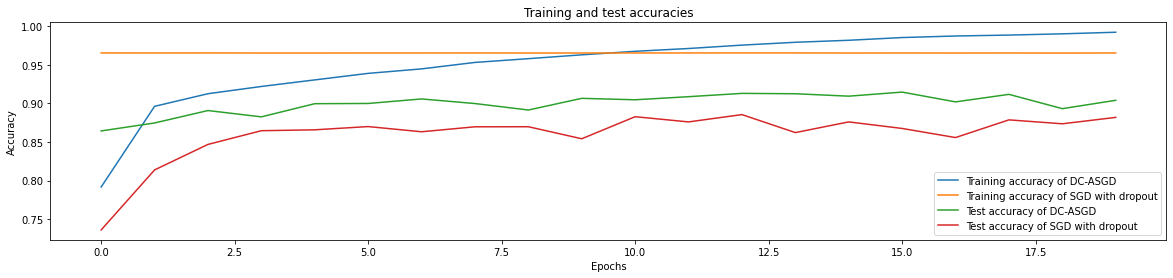

In [16]:
# Runs the comparison between the networks on the MNIST dataset
comparison(20, mnist_train, mnist_valid, batch_size = 256, base_lr = 0.03, lmbd = 0.01, momentum = 0.0)

## Testing with CIFAR10 dataset

In [27]:
# Loads the FashionMNIST dataset :
fmnist_train = datasets.FashionMNIST(train=True)
fmnist_valid = datasets.FashionMNIST(train=False)

  5%|▌         | 1/20 [00:14<04:40, 14.75s/it]

Epoch 0: loss 0.852, train acc 0.778, test acc 0.855, in 14.7 sec


 10%|█         | 2/20 [00:29<04:25, 14.75s/it]

Epoch 1: loss 0.518, train acc 0.897, test acc 0.878, in 14.7 sec


 15%|█▌        | 3/20 [00:44<04:13, 14.93s/it]

Epoch 2: loss 0.411, train acc 0.914, test acc 0.884, in 15.2 sec


 20%|██        | 4/20 [00:58<03:55, 14.70s/it]

Epoch 3: loss 0.357, train acc 0.925, test acc 0.890, in 14.3 sec


 25%|██▌       | 5/20 [01:13<03:39, 14.65s/it]

Epoch 4: loss 0.318, train acc 0.933, test acc 0.901, in 14.5 sec


 30%|███       | 6/20 [01:28<03:26, 14.73s/it]

Epoch 5: loss 0.292, train acc 0.941, test acc 0.892, in 14.9 sec


 35%|███▌      | 7/20 [01:42<03:10, 14.65s/it]

Epoch 6: loss 0.269, train acc 0.947, test acc 0.896, in 14.5 sec


 40%|████      | 8/20 [01:57<02:54, 14.57s/it]

Epoch 7: loss 0.248, train acc 0.953, test acc 0.903, in 14.4 sec


 45%|████▌     | 9/20 [02:11<02:39, 14.52s/it]

Epoch 8: loss 0.233, train acc 0.959, test acc 0.905, in 14.4 sec


 50%|█████     | 10/20 [02:26<02:24, 14.47s/it]

Epoch 9: loss 0.216, train acc 0.965, test acc 0.908, in 14.4 sec


 55%|█████▌    | 11/20 [02:40<02:09, 14.44s/it]

Epoch 10: loss 0.202, train acc 0.969, test acc 0.908, in 14.4 sec


 60%|██████    | 12/20 [02:54<01:55, 14.44s/it]

Epoch 11: loss 0.188, train acc 0.972, test acc 0.907, in 14.4 sec


 65%|██████▌   | 13/20 [03:09<01:40, 14.39s/it]

Epoch 12: loss 0.176, train acc 0.977, test acc 0.910, in 14.3 sec


 70%|███████   | 14/20 [03:23<01:26, 14.36s/it]

Epoch 13: loss 0.164, train acc 0.980, test acc 0.905, in 14.3 sec


 75%|███████▌  | 15/20 [03:37<01:11, 14.34s/it]

Epoch 14: loss 0.155, train acc 0.983, test acc 0.904, in 14.3 sec


 80%|████████  | 16/20 [03:52<00:57, 14.32s/it]

Epoch 15: loss 0.143, train acc 0.986, test acc 0.911, in 14.3 sec


 85%|████████▌ | 17/20 [04:06<00:42, 14.33s/it]

Epoch 16: loss 0.131, train acc 0.988, test acc 0.913, in 14.3 sec


 90%|█████████ | 18/20 [04:20<00:28, 14.38s/it]

Epoch 17: loss 0.123, train acc 0.990, test acc 0.908, in 14.5 sec


 95%|█████████▌| 19/20 [04:35<00:14, 14.36s/it]

Epoch 18: loss 0.115, train acc 0.992, test acc 0.912, in 14.3 sec


100%|██████████| 20/20 [04:50<00:00, 14.51s/it]


Epoch 19: loss 0.108, train acc 0.992, test acc 0.905, in 15.0 sec


  5%|▌         | 1/20 [00:13<04:17, 13.56s/it]

Epoch 0: loss 1.436, train acc 0.971, test acc 0.743, in 13.6 sec


 10%|█         | 2/20 [00:26<03:58, 13.26s/it]

Epoch 1: loss 1.173, train acc 0.971, test acc 0.829, in 13.1 sec


 15%|█▌        | 3/20 [00:39<03:42, 13.11s/it]

Epoch 2: loss 1.048, train acc 0.971, test acc 0.824, in 12.9 sec


 20%|██        | 4/20 [00:52<03:27, 12.98s/it]

Epoch 3: loss 0.988, train acc 0.971, test acc 0.856, in 12.8 sec


 25%|██▌       | 5/20 [01:05<03:13, 12.92s/it]

Epoch 4: loss 0.968, train acc 0.971, test acc 0.878, in 12.8 sec


 30%|███       | 6/20 [01:18<03:00, 12.93s/it]

Epoch 5: loss 0.965, train acc 0.971, test acc 0.864, in 12.9 sec


 35%|███▌      | 7/20 [01:31<02:48, 12.94s/it]

Epoch 6: loss 0.957, train acc 0.971, test acc 0.878, in 13.0 sec


 40%|████      | 8/20 [01:44<02:36, 13.04s/it]

Epoch 7: loss 0.954, train acc 0.971, test acc 0.876, in 13.2 sec


 45%|████▌     | 9/20 [01:57<02:23, 13.03s/it]

Epoch 8: loss 0.955, train acc 0.971, test acc 0.872, in 13.0 sec


 50%|█████     | 10/20 [02:10<02:09, 12.99s/it]

Epoch 9: loss 0.953, train acc 0.971, test acc 0.876, in 12.9 sec


 55%|█████▌    | 11/20 [02:23<01:56, 12.94s/it]

Epoch 10: loss 0.951, train acc 0.971, test acc 0.879, in 12.8 sec


 60%|██████    | 12/20 [02:35<01:43, 12.90s/it]

Epoch 11: loss 0.952, train acc 0.971, test acc 0.870, in 12.8 sec


 65%|██████▌   | 13/20 [02:48<01:30, 12.90s/it]

Epoch 12: loss 0.950, train acc 0.971, test acc 0.876, in 12.9 sec


 70%|███████   | 14/20 [03:01<01:17, 12.92s/it]

Epoch 13: loss 0.947, train acc 0.971, test acc 0.876, in 13.0 sec


 75%|███████▌  | 15/20 [03:14<01:04, 12.91s/it]

Epoch 14: loss 0.947, train acc 0.971, test acc 0.876, in 12.9 sec


 80%|████████  | 16/20 [03:27<00:51, 12.88s/it]

Epoch 15: loss 0.948, train acc 0.971, test acc 0.857, in 12.8 sec


 85%|████████▌ | 17/20 [03:40<00:38, 12.89s/it]

Epoch 16: loss 0.947, train acc 0.971, test acc 0.848, in 12.9 sec


 90%|█████████ | 18/20 [03:53<00:25, 12.87s/it]

Epoch 17: loss 0.948, train acc 0.971, test acc 0.884, in 12.8 sec


 95%|█████████▌| 19/20 [04:06<00:12, 12.92s/it]

Epoch 18: loss 0.946, train acc 0.971, test acc 0.876, in 13.0 sec


100%|██████████| 20/20 [04:19<00:00, 12.96s/it]

Epoch 19: loss 0.948, train acc 0.971, test acc 0.873, in 13.0 sec


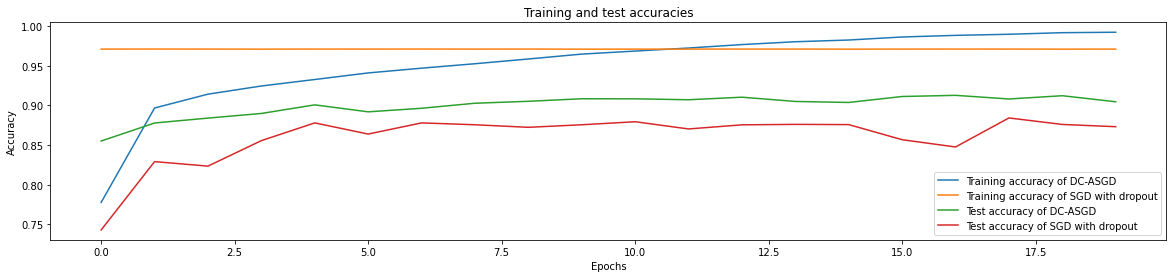

In [31]:
# Runs the comparison between the two networks on the FashionMNIST dataset :
comparison(20, fmnist_train, fmnist_valid, batch_size = 256, base_lr = 0.03, lmbd = 0.01, momentum = 0.0)